In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform
        self.file_names = [os.path.basename(path) for path in file_paths]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        data = torch.load(self.file_paths[idx], weights_only=True)
        
        images = data[:6]  
        labels = data[6]           
        
        images = images.float()  
        labels = labels.long()

        if self.transform:
            images = self.transform(images)
            labels = self.transform(labels)
        
        return images, labels, self.file_names[idx]

def generate_file_paths(base_path):
    file_paths = []
    for frame in os.listdir(base_path):
        frame_path = os.path.join(base_path, frame)
        if frame_path.endswith('.mat.pt'):
            file_paths.append(frame_path)
    return [path for path in file_paths if os.path.exists(path)]

def load_data(base_path, batch_size=4, num_workers=2, test_size=0.2):
    file_paths = generate_file_paths(base_path)
    
    train_paths, test_paths = train_test_split(file_paths, test_size=test_size, random_state=42)
    
    train_dataset = CustomDataset(file_paths=train_paths)
    test_dataset = CustomDataset(file_paths=test_paths)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        drop_last=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        drop_last=True
    )
    
    return train_loader, test_loader

In [2]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import pickle
import os
import sys
sys.path.append('/bohr/train-4gug/v2')

data_path = '/bohr/train-4gug/v2/training_set'
train_loader, test_loader = load_data(
    base_path=data_path,
    batch_size=32,  
    test_size=0.2
)

### Data visualization

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

def visualize_pt_file(idx):
    file_path = f'/bohr/train-4gug/v2/training_set/{idx}.mat.pt'
    data = torch.load(file_path)
    num_images = data.shape[0]
    cols = 3
    rows = (num_images + cols - 1) // cols

    fig = plt.figure(figsize=(cols * 5.5, rows * 5.5), constrained_layout=True)

    gs = gridspec.GridSpec(rows, cols, figure=fig)

    colors = ['black', 'yellow']
    cmap_discrete = ListedColormap(colors)

    for i in range(num_images):
        img = data[i].numpy().squeeze()
        img = np.flipud(img)

        if i < 6:

            ax = fig.add_subplot(gs[i // cols, i % cols], projection='polar')
            height, width = img.shape
            angles = np.linspace(-90, 90, width)
            distances = np.linspace(0, 50, height)
            angles_rad = np.radians(angles)
            theta, r = np.meshgrid(angles_rad, distances)
            im = ax.pcolormesh(theta, r, img, shading='auto')

            ax.set_thetalim(np.radians(-90), np.radians(90))
            ax.set_rlim(0, 50)
            ax.set_thetagrids(np.arange(-90, 91, 30))
            ax.set_rticks([0, 10, 20, 30, 40, 50])
            ax.set_rlabel_position(45)
            ax.set_title(f'Index {i}', pad=20)

            plt.colorbar(im, ax=ax, shrink=0.8, label='Intensity')

        else:
            ax = fig.add_subplot(gs[2, :])
            height, width = img.shape
            img_normalized = img + 1
            im = ax.imshow(img_normalized, extent=[-90, 90, 0, height],
                          cmap=cmap_discrete, vmin=0, vmax=4, aspect='auto')

            ax.set_xlabel(f'X Axis of item {idx}')
            ax.set_ylabel('Y Axis')
            ax.set_title(f'Index {i} (Labels) of {idx}')

            x_ticks = np.linspace(-90, 90, 7)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels([f'{int(x)}' for x in x_ticks])

            y_ticks = np.linspace(0, height, 6)
            ax.set_yticks(y_ticks)
            ax.set_yticklabels([f'{int(y)}' for y in y_ticks])

            ax.grid(True, linestyle='--', alpha=0.5)

            legend_elements = [
                Patch(facecolor='black', label='Background'),
                Patch(facecolor='yellow', label='Human')
            ]

            ax.legend(handles=legend_elements,
                      loc='best',
                      fontsize='large')

    plt.show()

In [4]:
str_list = [21,23,35,43,49,66,70,76,80,91,96,98,106,111,127]
idx = 10
#visualize_pt_file(idx)

In [5]:
class MyModel(nn.Module):
    def __init__(self, in_channels=6, d=32,dp=0.5):
        super().__init__()
        self.d = d
        self.dp = dp
        self.encoder1 = self.conv_block(in_channels, d)
        self.encoder2 = self.conv_block(d, d*2)
        self.encoder3 = self.conv_block(d*2, d*4)
        self.encoder4 = self.conv_block(d*4, d*8)

        self.pool = nn.MaxPool2d(2)

        self.mid = self.conv_block(d*8, d*16)

        self.up4 = nn.ConvTranspose2d(d*16, d*8, 2, stride=2)
        self.dec4 = self.conv_block(d*16, d*8)
        self.up3 = nn.ConvTranspose2d(d*8, d*4, 2, stride=2)
        self.dec3 = self.conv_block(d*8, d*4)
        self.up2 = nn.ConvTranspose2d(d*4, d*2, 2, stride=2)
        self.dec2 = self.conv_block(d*4, d*2)
        self.up1 = nn.ConvTranspose2d(d*2, d, 2, stride=2)
        self.dec1 = self.conv_block(d*2, d)

        self.final = nn.Conv2d(d, 2, kernel_size=1)

        self.kernel = torch.ones(1,1,3,3).cuda()

    def conv_block(self, in_ch, out_ch):
        
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(self.dp),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(self.dp)
        )

    def forward(self, x, switch=0):
        '''
        输入：B * 7 * 50 * 181

        输出：B * 1 * 50 * 181
        '''

        x = x[:, :, 1:49, 2:178]

        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        
        m = self.mid(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        out = self.final(d1)  

        padding = (2, 3, 1, 1)
        out = F.pad(out, padding, mode='constant', value=0)
        #return out                                                      ### <---- 控制器在此
        if switch==0:
            return out
        else:
            #out = F.conv2d(out, self.kernel, padding=1)
            c1 = torch.zeros((out.size(0),50,181))
            for b in range (out.size(0)):
                for x in range (1,49):
                    for y in range (1,180):
                        if (out[b,1,x-1:x+2,y:y+1]>=0.5).any().item():  ### 改变增扩方式
                            c1[b,x,y]=10
            out[:,1,:,:]=c1
            return out

In [6]:
tensor = torch.zeros(1,1,10,10)
for i in range (5,9):
    for j in range (3,8):
        tensor[0,0,i,j]=1
print(tensor)
transforms.Resize((10,1))(tensor)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
          [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])


tensor([[[[0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.5800],
          [0.5800],
          [0.5800],
          [0.5800],
          [0.0000]]]])

In [9]:
def cal_accuracy(model, test_loader, bonus=1500,switch=0):
    model.eval()
    total_score = 0
    total_theo = 0
    total_fn = [0,0]

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            outputs = model(images,switch=switch)
            outputs = torch.argmax(outputs, dim=1)

            equal_mask = outputs == labels  # correctly predicted masks
            neg_one_mask = labels == 0      # Mask of background categories

            for jj in range (images.size(0)):
                pred_image = outputs[jj]
                label_image = labels[jj]
                diff = pred_image - label_image
                if (diff==-1).any().item():
                    total_fn[0]+=1
                result = torch.zeros_like(pred_image)
                result[diff == -1] = 1
                total_fn[1] += result.sum().item()

            # Calculate the score
            score_neg_one = (equal_mask & neg_one_mask).sum() * 1  # Background category score
            score_other = (equal_mask & ~neg_one_mask).sum() * bonus  # Target category score
            score_theo = neg_one_mask.sum() * 1 + (~neg_one_mask).sum() * bonus  # Full marks in theory

            total_score += score_neg_one + score_other
            total_theo += score_theo

    score = total_score.item() / total_theo.item()
    return score, total_fn

class LessOnesLoss(nn.Module):
    def __init__(self):
        super(LessOnesLoss, self).__init__()

    def forward(self, output, target):
        probs = torch.softmax(output, dim=1)
        class1_probs = probs[:, 1, :, :] # 得 B*H*W
        class1_mask = (target == 1).float() # B*H*W
        return torch.mean(torch.abs(class1_probs - class1_mask))
        loss = torch.zeros(1).cuda()
        for i in range (class1_probs.size(0)):
            item = torch.mean(torch.abs(class1_probs[i] - class1_mask[i]))
            if item >= 0.2:
                loss+=item**2
            elif item >= 0.11:
                loss+=item
            else:
                continue        
        return loss

def train(model, train_loader, test_loader, optimizer, criterion, num_epochs=100):

    model.cuda()
    less1 = LessOnesLoss()
    
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores =[]

    test_score_on, test_score = 0, 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        
        for images, labels, _ in train_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels
            
            outputs = model(images)
            temp = less1(outputs,labels)
            outputs = outputs.view(outputs.size(0), outputs.size(1), -1)  # [B, C, H*W]
            labels = labels.view(labels.size(0), -1)  # [B, H*W]
            loss = criterion(outputs, labels) + temp * 1.8
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for images, labels, _ in test_loader:
                images = images.cuda() if torch.cuda.is_available() else images
                labels = labels.cuda() if torch.cuda.is_available() else labels
                
                outputs = model(images)
                outputs = outputs.view(outputs.size(0), outputs.size(1), -1)
                labels = labels.view(labels.size(0), -1)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_batch_count += 1

        avg_val_loss = val_loss / val_batch_count
        val_losses.append(avg_val_loss)
        
        if epoch>=0:
            train_score, train_fn = 0,0 #cal_accuracy(model,train_loader)
            test_score, test_fn = cal_accuracy(model,test_loader)
            val_scores.append(test_score)
            train_scores.append(train_score)
            print(f'Epoch [{epoch+1:02d}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:02.4f}, '
                  f'Train Score: {train_score:.4f}, '
                  f'Train FN: {train_fn}       '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Test Score: {test_score:.4f}, '
                  f'Test FN: {test_fn}')
            
        if epoch>=10:
            test_score_on, test_fn_on = cal_accuracy(model,test_loader,switch=1)
            print(f'With Switch On: '
                  f'Test Score: {test_score_on:.4f}, '
                  f'Test FN: {test_fn_on}')

        if test_score_on>=0.994:
            print(f"With On, Early Stop at Epoch {epoch+1:02d}, Test FN: {test_fn_on}, Test Score: {test_score_on:.4f}")
            break

        if test_score>=0.994:
            print(f"With Off, Early Stop at Epoch {epoch+1:02d}, Test FN: {test_fn}, Test Score: {test_score:.4f}")
            break
    
    return train_scores, val_scores

In [10]:
model = MyModel(d=32,dp=0.0)
if torch.cuda.is_available():
    model = model.cuda()

class_weights = [1., 1500.]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=0.0003) 

train_scores, val_scores = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=15
)

16


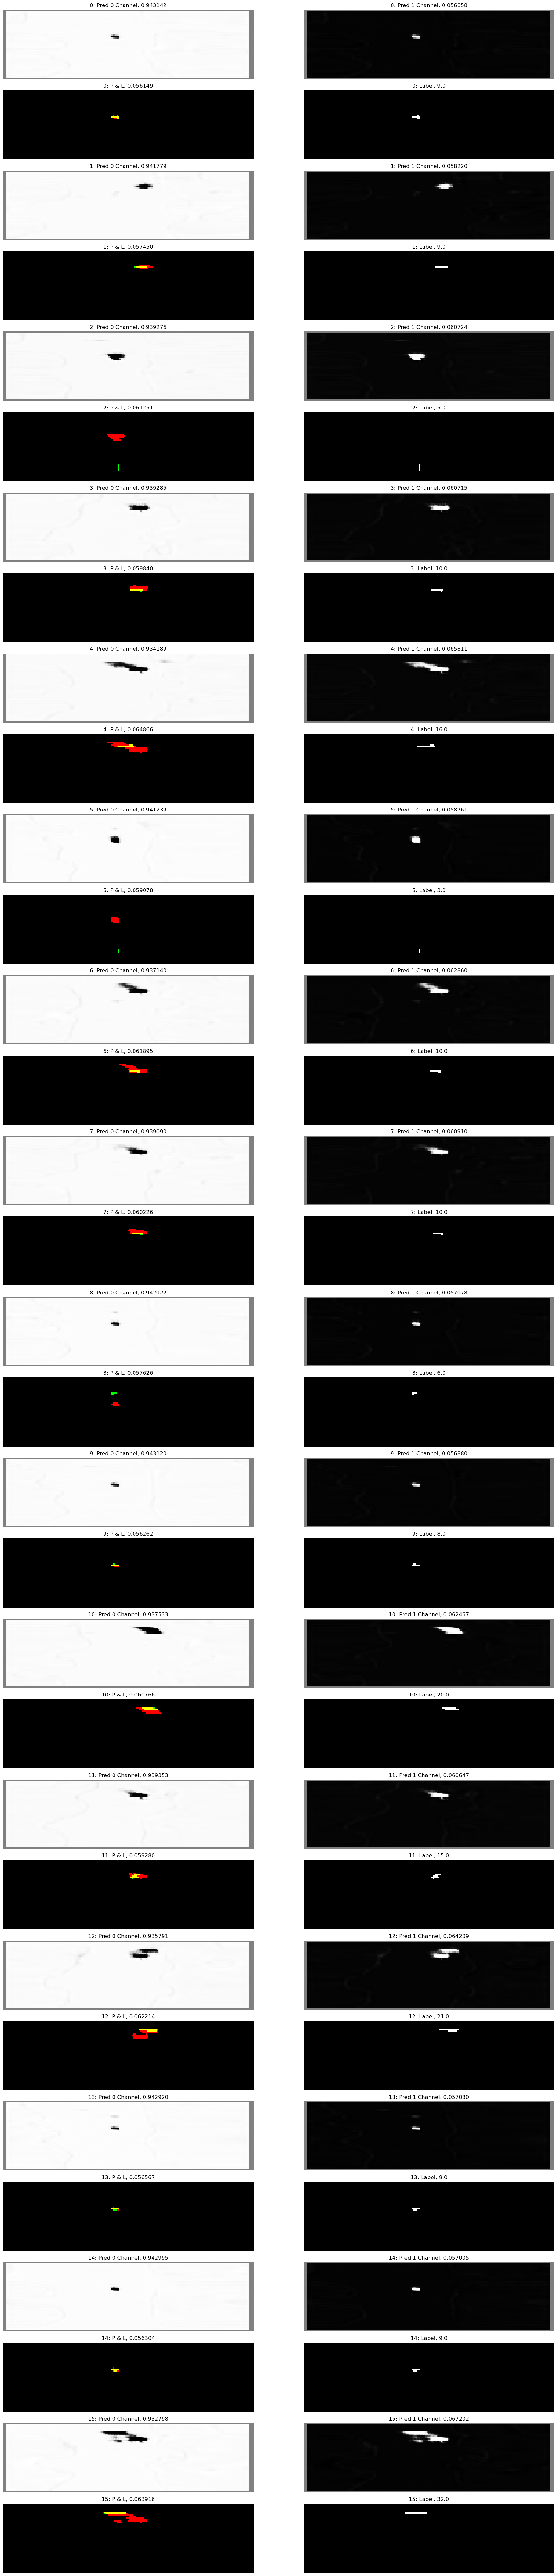

In [15]:
t=1
switch=0
if t==1:
    model.eval()
    tensor1 = torch.zeros((1,50,181)).cuda()
    tensor2 = torch.zeros((1,50,181)).cuda()
    tensor3 = torch.zeros((1,2,50,181)).cuda()
    softmax = torch.nn.Softmax(dim=1)
    for inputs, labels, _ in test_loader:
        inputs = inputs.cuda() if torch.cuda.is_available() else inputs
        labels = labels.cuda() if torch.cuda.is_available() else labels
        outputs = model(inputs,switch=switch)
        probabilities = softmax(outputs)
        predictions = torch.argmax(probabilities, dim=1)
        for jj in range (inputs.size(0)):
            pred_image = predictions[jj]
            label_image = labels[jj]
            diff = pred_image - label_image
            if torch.any(diff==-1):
                tensor1 = torch.cat([tensor1,pred_image.unsqueeze(0)],axis=0)
                tensor2 = torch.cat([tensor2,label_image.unsqueeze(0)],axis=0)
                tensor3 = torch.cat([tensor3,probabilities[jj].unsqueeze(0)],axis=0)
    
    predictions = tensor1[1:]
    labels = tensor2[1:]
    probabilities = tensor3[1:]
    print(labels.size(0))

else:
    model.eval()
    inputs, labels, _ = next(iter(test_loader))
    inputs = inputs.cuda() if torch.cuda.is_available() else inputs
    labels = labels.cuda() if torch.cuda.is_available() else labels
    
    outputs = model(inputs,switch=switch)
    
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(outputs)
    predictions = torch.argmax(probabilities, dim=1)


fig, axes = plt.subplots(predictions.size(0)*2, 2, figsize=(20, predictions.size(0)*5))
for i in range(predictions.size(0)):

    sum = probabilities[i,0,:,:].mean().cpu().detach().numpy()
    axes[i*2, 0].imshow(probabilities[i,0,:,:].cpu().detach().numpy(), cmap='gray')
    axes[i*2, 0].set_title(f'{i}: Pred 0 Channel, {sum:.6f}')
    axes[i*2, 0].axis('off')

    sum = probabilities[i,1,:,:].mean().cpu().detach().numpy()
    axes[i*2, 1].imshow(probabilities[i,1,:,:].cpu().detach().numpy(), cmap='gray')
    axes[i*2, 1].set_title(f'{i}: Pred 1 Channel, {sum:.6f}')
    axes[i*2, 1].axis('off')


    pred_image = predictions[i].cpu().numpy()
    '''
    axes[i*2+1, 0].imshow(pred_image, cmap='gray')
    axes[i*2+1, 0].set_title(f'{i}: Prediction, {sum:.4f}')
    axes[i*2+1, 0].axis('off')
    '''

    label_image = labels[i].cpu().numpy()
    sum = label_image.sum()
    axes[i*2+1, 1].imshow(label_image, cmap='gray')
    axes[i*2+1, 1].set_title(f'{i}: Label, {sum}')
    axes[i*2+1, 1].axis('off')

    sum = torch.abs(probabilities[i,1,:,:]-labels[i]).mean().cpu().detach().numpy()
    pred_color = np.stack([pred_image * 255, pred_image * 0, pred_image * 0], axis=-1)
    label_color = np.stack([label_image * 0, label_image * 255, label_image * 0], axis=-1) 
    combined_image = (pred_color + label_color).astype(int)
    axes[i*2+1, 0].imshow(combined_image, cmap=None)
    axes[i*2+1, 0].set_title(f'{i}: P & L, {sum:.6f}')
    axes[i*2+1, 0].axis('off')

plt.tight_layout()
plt.show()

In [694]:
def plot_learning_curve(train, test):
    plt.figure(figsize=(10, 5))
    plt.plot(train, marker='o', linestyle='-', color='r',label='train')
    plt.plot(test, marker='o', linestyle='-', color='b',label='test')
    max_train = max(train)
    max_train_index = train.index(max_train)
    plt.annotate(f'Max Train: {max_train:.4f}', 
                 xy=(max_train_index, max_train), 
                 xytext=(max_train_index+1, max_train),
                 arrowprops=dict(facecolor='red', shrink=0.01))
    max_test = max(test)
    max_test_index = test.index(max_test)
    plt.annotate(f'Max Test: {max_test:.4f}', 
                 xy=(max_test_index, max_test), 
                 xytext=(max_test_index+1, max_test),
                 arrowprops=dict(facecolor='blue', shrink=0.05))
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_learning_curve(train_scores[1:], val_scores[1:])